# Model 2
### Project: Exploring Trends in US Happiness with Census Data
Team Members: Taylor Witte, Donald Yu, Praveen Manimaran, Vitush Agarwal, Parker Aman

UCSD Spring 2024 232R Big Data Analytics Using Spark 


## Enviroment Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import logging
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, element_at, udf
from pyspark.sql.functions import explode
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
from pyspark.sql import Row
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.functions import when
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml import Pipeline
from sklearn.model_selection import train_test_split
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, PCA, PCAModel
from pyspark.sql.types import ArrayType, DoubleType, NumericType
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import pylab as pl
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

## Import Datasets

### Import World Happiness Data

In [2]:
# Import necessary modules
from pyspark.sql import SparkSession

# Create a SparkSession object
spark = SparkSession.builder \
    .appName("BigDataGroupProject") \
    .config("spark.some.config.option", "some-value") \
    .config("spark.executor.memory", "64g") \
    .config("spark.driver.memory", "64g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.3") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

24/06/08 08:32:32 WARN Utils: Your hostname, Taylors-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.4.60 instead (on interface en0)
24/06/08 08:32:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/08 08:32:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
#World Happiness Data
world_happiness = pd.read_csv("C:/Users/Parker Aman/dev/Dev_School/Big Data/Group Project/World Happiness Report.csv")

# Filter for USA & years of cencus data
US_happiness =  world_happiness.loc[world_happiness['Country Name'] == 'United States']
US_happiness = US_happiness[US_happiness.Year >= 2012]
US_happiness = US_happiness[US_happiness.Year != 2020]


In [4]:
#World Happiness Results 
happiness_rank = pd.read_csv("C:/Users/Parker Aman/dev/Dev_School/Big Data/Group Project/World_Happiness_Index.csv"
)

# Filter for USA & years of cencus data
happiness_rank = happiness_rank.loc[happiness_rank['Country'] == 'United States']
happiness_rank = happiness_rank[happiness_rank.Year != 2023]
happiness_rank = happiness_rank[happiness_rank.Year != 2020]
happiness_rank = happiness_rank.rename(columns={'Country': 'Country Name', 'Year':'Year','Index':'Happiness_Index',
                       'Rank':'Happiness_Rank'})
happiness_rank

,Country Name,Year,Happiness_Index,Happiness_Rank
1444,United States,2013,7.082,17
1445,United States,2015,7.119,15
1446,United States,2016,7.104,13
1447,United States,2017,6.993,14
1448,United States,2018,6.886,18
1449,United States,2019,6.892,19
1451,United States,2021,6.951,19
1452,United States,2022,6.977,16
1523,United States,2012,7.270,6


### Import Individual Census Data

In [3]:
#Import Individual Census Data 

# Define the path to the CSV file
file_path = "usa_00006.csv"
 #change this to your own!!

# Read the CSV file into a DataFrame
df_id = spark.read.csv(file_path, header=True, inferSchema=True)

#Normalize Monitary Values to 2000 with CPI99
df_id = df_id.withColumn('AINCTOT', df_id.INCTOT * df_id.CPI99)
df_id = df_id.withColumn('AFTOTINC', df_id.FTOTINC * df_id.CPI99)
df_id = df_id.withColumn('AINCWELFR', df_id.INCWELFR * df_id.CPI99)
df_id = df_id.withColumn('AINCINVST', df_id.INCINVST * df_id.CPI99)
#df_id = df_id.withColumn('APOVERTY', df_id.POVERTY * df_id.CPI99)
#Store raw monetary values
raw_id = df_id.select('SAMPLE', 'CBSERIAL', 'INCTOT', 'FTOTINC', 'INCWELFR', 'INCINVST')
#Remove raw monetary value from dataframe 
df_id = df_id.drop('INCTOT', 'FTOTINC', 'INCWELFR', 'INCINVST')

# Show the schema of the DataFrame
df_id.printSchema()

# Show the first few rows of the DataFrame
df_id.show(5)

root
 |-- YEAR: integer (nullable = true)
 |-- SAMPLE: integer (nullable = true)
 |-- SERIAL: integer (nullable = true)
 |-- CBSERIAL: long (nullable = true)
 |-- HHWT: double (nullable = true)
 |-- CLUSTER: long (nullable = true)
 |-- CPI99: double (nullable = true)
 |-- STRATA: integer (nullable = true)
 |-- GQ: integer (nullable = true)
 |-- PERNUM: integer (nullable = true)
 |-- CBPERNUM: integer (nullable = true)
 |-- PERWT: double (nullable = true)
 |-- FAMSIZE: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- MARST: integer (nullable = true)
 |-- RACE: integer (nullable = true)
 |-- RACED: integer (nullable = true)
 |-- CITIZEN: integer (nullable = true)
 |-- HCOVANY: integer (nullable = true)
 |-- SCHOOL: integer (nullable = true)
 |-- EDUC: integer (nullable = true)
 |-- EDUCD: integer (nullable = true)
 |-- SCHLTYPE: integer (nullable = true)
 |-- EMPSTAT: integer (nullable = true)
 |-- EMPSTATD: integer (nullable = true)


### Import Household Census Data

In [4]:
#Import Household Census Data 

# Define the path to the CSV file
file_path = "usa_00007.csv" #change this to your own!!

# Read the CSV file into a DataFrame
df_hh = spark.read.csv(file_path, header=True, inferSchema=True)

#Since rows represent individuals but we want households remove duplicates
df_hh = df_hh.dropDuplicates()

# Normalize monetary values to 2000 standard with CP199 multiplier
df_hh = df_hh.withColumn('ARENTGRS', df_hh.RENTGRS * df_hh.CPI99)
df_hh = df_hh.withColumn('ACONDOFEE', df_hh.CONDOFEE * df_hh.CPI99)
df_hh = df_hh.withColumn('AMOBLHOME', df_hh.MOBLHOME * df_hh.CPI99)
df_hh = df_hh.withColumn('AHHINCOME', df_hh.HHINCOME * df_hh.CPI99)
df_hh = df_hh.withColumn('AVALUEH', df_hh.VALUEH * df_hh.CPI99)
df_hh = df_hh.withColumn('ACOSTELEC', df_hh.COSTELEC * df_hh.CPI99)
df_hh = df_hh.withColumn('ACOSTGAS', df_hh.COSTGAS * df_hh.CPI99)
df_hh = df_hh.withColumn('ACOSTWATR', df_hh.COSTWATR * df_hh.CPI99)
df_hh = df_hh.withColumn('ACOSTFUEL', df_hh.COSTFUEL * df_hh.CPI99)

#Store raw monetary values
raw_id = df_hh.select('SAMPLE', 'RENTGRS', 'CONDOFEE', 'MOBLHOME', 'HHINCOME',
                       'VALUEH', 'COSTELEC', 'COSTGAS', 'COSTWATR', 'COSTFUEL')
#Remove raw monetary value from dataframe 
df_hh = df_hh.drop('RENTGRS', 'CONDOFEE', 'MOBLHOME', 'HHINCOME',
                    'VALUEH', 'COSTELEC', 'COSTGAS', 'COSTWATR', 'COSTFUEL')

# Show the schema of the DataFrame
df_hh.printSchema()

# Show the first few rows of the DataFrame
df_hh.show(5)

root
 |-- YEAR: integer (nullable = true)
 |-- SAMPLE: integer (nullable = true)
 |-- SERIAL: integer (nullable = true)
 |-- CBSERIAL: long (nullable = true)
 |-- HHWT: double (nullable = true)
 |-- HHTYPE: integer (nullable = true)
 |-- CLUSTER: long (nullable = true)
 |-- CPI99: double (nullable = true)
 |-- STATEICP: integer (nullable = true)
 |-- MET2023: integer (nullable = true)
 |-- STRATA: integer (nullable = true)
 |-- GQ: integer (nullable = true)
 |-- FARM: integer (nullable = true)
 |-- OWNERSHP: integer (nullable = true)
 |-- OWNERSHPD: integer (nullable = true)
 |-- TAXINCL: integer (nullable = true)
 |-- INSINCL: integer (nullable = true)
 |-- FOODSTMP: integer (nullable = true)
 |-- CINETHH: integer (nullable = true)
 |-- VEHICLES: integer (nullable = true)
 |-- COUPLETYPE: integer (nullable = true)
 |-- NFAMS: integer (nullable = true)
 |-- ARENTGRS: double (nullable = true)
 |-- ACONDOFEE: double (nullable = true)
 |-- AMOBLHOME: double (nullable = true)
 |-- AHHINCOM

+----+------+------+-------------+-------+------+-------------+-----+--------+-------+------+---+----+--------+---------+-------+-------+--------+-------+--------+----------+-----+--------+---------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|YEAR|SAMPLE|SERIAL|     CBSERIAL|   HHWT|HHTYPE|      CLUSTER|CPI99|STATEICP|MET2023|STRATA| GQ|FARM|OWNERSHP|OWNERSHPD|TAXINCL|INSINCL|FOODSTMP|CINETHH|VEHICLES|COUPLETYPE|NFAMS|ARENTGRS|ACONDOFEE|         AMOBLHOME|         AHHINCOME|           AVALUEH|         ACOSTELEC|          ACOSTGAS|         ACOSTWATR|         ACOSTFUEL|
+----+------+------+-------------+-------+------+-------------+-----+--------+-------+------+---+----+--------+---------+-------+-------+--------+-------+--------+----------+-----+--------+---------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|

### Combine Household and Individual Census Data (Preprocessed)

In [5]:
## Preprocessing for Individual 

#LOOKING: combine not reported and n/a
df_id = df_id.withColumn("LOOKING", when(df_id["LOOKING"] == 3, 0).otherwise(df_id["LOOKING"])) 
#Group Quarters: Combine Household types and Group Quarter Types 
df_id = df_id.withColumn("GQ", when(df_id["GQ"] == 2, 1).when(df_id["GQ"] == 5, 1).when(df_id["GQ"] == 4, 3).otherwise(df_id["GQ"]))

#Remove Varaibles 
var_remove = ['SAMPLE', 'SERIAL', 'HHWT', 'PERNUM', 'CLUSTER', 'CPI99', 'STRATA',
              'PERWT', 'RACED', 'EDUCD', 'EMPSTATD', 'CLASSWKRD']
df_id = df_id.drop(*var_remove)


In [47]:
## Preprocessing for Household 
#Group Quarters: Combine Household types and Group Quarter Types 
df_hh = df_hh.withColumn("GQ", when(df_hh["GQ"] == 2, 1).when(df_hh["GQ"] == 5, 1).when(df_hh["GQ"] == 4, 3).otherwise(df_hh["GQ"]))
#Household Types: combine NA and could not be determined
df_hh = df_hh.withColumn("HHTYPE", when(df_hh["HHTYPE"] == 9, 0).otherwise(df_hh["HHTYPE"]))
#Fix CINETHH None values with Na encoded as 0 
df_hh = df_hh.na.fill(value=0, subset=['CINETHH'])

#Remove Varaibles 
var_remove = ['SAMPLE', 'SERIAL', 'HHWT', 'CLUSTER', 'CPI99', 'STRATA',
              'MET2023', 'TAXINCL', 'INSINCL', 'COUPLETYPE']
df_hh = df_hh.drop(*var_remove)

# Create a new column for all Utilities by combining individual costs of gas, electricity, fuel, and water
# and drop old columns

df_hh = df_hh.withColumn('COSTUTIL', 
                         df_hh['ACOSTELEC'] + df_hh['ACOSTGAS'] + df_hh["ACOSTWATR"] + df_hh['ACOSTFUEL'])

df_hh = df_hh.drop('ACOSTELEC', 'ACOSTGAS', 'ACOSTWATR', 'ACOSTFUEL')

In [6]:
# Test Combining Individual & Household Data 
df_h = df_hh.drop('GQ') #drop duplicate columns 
result_df = df_id.join(df_h, on=["CBSERIAL","YEAR"], how="left")
result_df = result_df.dropDuplicates()
result_df.count()
#result_df.printSchema()
from pyspark.sql.functions import count
result_df.groupBy("YEAR").agg(count("*").alias("count")).show()

+----+-------+
|YEAR|  count|
+----+-------+
|2018|1000701|
|2015|1002140|
|2022|1000453|
|2013|1001492|
|2014|1000578|
|2019| 999725|
|2012| 997299|
|2016| 997981|
|2017|1000345|
|2021| 999712|
+----+-------+



In [41]:
result_df.show(10)

+--------+----+------+-------+------+-------------+-----+-------+---+------+--------+------+-------+---+---+-----+----+-----+-------+-------+------+----+-----+--------+-------+--------+--------+---------+--------+-------+-------+------------------+------------------+---------+----------+------+-------+------+------+-------------+-----+--------+-------+-------+----+--------+---------+-------+-------+--------+-------+--------+----------+-----+--------+---------+---------+------------------+-----------+------------------+--------+---------+---------+
|CBSERIAL|YEAR|SAMPLE| SERIAL|  HHWT|      CLUSTER|CPI99| STRATA| GQ|PERNUM|CBPERNUM| PERWT|FAMSIZE|SEX|AGE|MARST|RACE|RACED|CITIZEN|HCOVANY|SCHOOL|EDUC|EDUCD|SCHLTYPE|EMPSTAT|EMPSTATD|CLASSWKR|CLASSWKRD|UHRSWORK|LOOKING|POVERTY|           AINCTOT|          AFTOTINC|AINCWELFR| AINCINVST|SAMPLE| SERIAL|  HHWT|HHTYPE|      CLUSTER|CPI99|STATEICP|MET2023| STRATA|FARM|OWNERSHP|OWNERSHPD|TAXINCL|INSINCL|FOODSTMP|CINETHH|VEHICLES|COUPLETYPE|NFAMS|A

### Split test/train data

In [ ]:
# Split datasets into train and test

id_norm_train, id_norm_test = id_norm.randomSplit(weights=[0.8,0.2], seed=200)
hh_norm_train, hh_norm_test = hh_norm.randomSplit(weights=[0.8,0.2], seed=200)


DataFrame[YEAR: double, HHTYPE: double, STATEICP: double, GQ: double, FARM: double, OWNERSHP: double, OWNERSHPD: double, FOODSTMP: double, CINETHH: double, VEHICLES: double, NFAMS: double, ARENTGRS: double, ACONDOFEE: double, AMOBLHOME: double, AHHINCOME: double, AVALUEH: double, COSTUTIL: double, features: vector]

## Household Decision Tree

In [12]:
#Split unnormalized data 
hh_train, hh_test = df_hhN.randomSplit(weights=[0.8,0.2], seed=200)

In [13]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [14]:
print(df_hhN.filter((col("OWNERSHP") == 1) & (col("ARENTGRS") > 0)).count())
print(df_hhN.filter((col("OWNERSHP") == 1) & (col("ARENTGRS") == 0)).count())

0
2757352


Adjusted gross rent will be removed since it is not collected for owned homes. 

In [15]:
features = hh_train.columns
features.remove("OWNERSHPD")
features.remove("OWNERSHP")
features.remove('ARENTGRS')

In [16]:
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(hh_train)
dt_classifier = DecisionTreeClassifier(labelCol="OWNERSHP", featuresCol="features")
model = dt_classifier.fit(data)

In [ ]:
#predictions_train = model.transform(data)
test_data = assembler.transform(hh_test)
predictions_test = model.transform(test_data)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="OWNERSHP", predictionCol="prediction", metricName="accuracy")

#accuracy_train = evaluator.evaluate(predictions_train)
accuracy_test = evaluator.evaluate(predictions_test)

#print(f"Training Accuracy: {accuracy_train}")
print(f"Test Accuracy: {accuracy_test}")

Test Accuracy: 0.9990159327876406


In [ ]:
feature_importance = model.featureImportances.toArray()

# Show feature importance
for i, column in enumerate(assembler.getInputCols()):
    print(f"Feature '{column}': {feature_importance[i]:.2f}")

Feature 'YEAR': 0.02
Feature 'HHTYPE': 0.00
Feature 'STATEICP': 0.00
Feature 'GQ': 0.29
Feature 'FARM': 0.00
Feature 'FOODSTMP': 0.00
Feature 'CINETHH': 0.00
Feature 'VEHICLES': 0.00
Feature 'NFAMS': 0.00
Feature 'ACONDOFEE': 0.00
Feature 'AMOBLHOME': 0.00
Feature 'AHHINCOME': 0.00
Feature 'AVALUEH': 0.69
Feature 'COSTUTIL': 0.00


In [ ]:
#print(tree_structure)

In [ ]:
# Mapping of features
feature_mapping = {
    0: "YEAR",
    1: "HHTYPE",
    2: "STATEICP",
    3: "GROUP_QUARTERS",
    4: "FARM",
    5: "FOODSTMP",
    6: "CINETHH",
    7: "VEHICLES",
    8: "NFAMS",
    9: "ACONDOFEE",
    10: "AMOBLHOME",
    11: "AHHINCOME",
    12: "HOUSE_VALUE",
    13: "COSTUTIL"
}
# Mapping of predicted class 
class_mapping = {
    0.0: "Na",
    1.0: "Own",
    2.0: "Rent"
}

# replace feature numbers and predicted class numbers with names and labels
def convert_tree_structure(tree_structure):
    lines = tree_structure.split("\n")
    converted_lines = []
    for line in lines:
        for feature_num, feature_name in feature_mapping.items():
            line = line.replace(f"feature {feature_num} ", f"{feature_name} ")
            line = line.replace(f"feature {feature_num}>", f"{feature_name}>")
            line = line.replace(f"feature {feature_num}<=", f"{feature_name}<=")
        for class_num, class_label in class_mapping.items():
            line = line.replace(f"Predict: {class_num}", f"Predict: {class_label}")
        converted_lines.append(line)
    return "\n".join(converted_lines)

tree_structure = model.toDebugString
converted_tree_structure = convert_tree_structure(tree_structure)
print(converted_tree_structure)


DecisionTreeClassificationModel: uid=DecisionTreeClassifier_22f4e8275e1b, depth=4, numNodes=9, numClasses=3, numFeatures=14
  If (HOUSE_VALUE <= 1243301.0)
   Predict: Own
  Else (HOUSE_VALUE > 1243301.0)
   If (GROUP_QUARTERS <= 2.0)
    If (HOUSE_VALUE <= 5919999.408)
     If (YEAR <= 2021.5)
      Predict: Own
     Else (YEAR > 2021.5)
      Predict: Rent
    Else (HOUSE_VALUE > 5919999.408)
     Predict: Rent
   Else (GROUP_QUARTERS > 2.0)
    Predict: Na



In [ ]:
#rent = hh_test.filter(col("OWNERSHP") == 2).count()
#total = hh_test.count()
print("Percent Rented:", (rent/total)*100)
gc = hh_test.filter(col("GQ") > 2).count()
print("Percent Group Quarters:", (gc/total)*100)

Percent Rented: 26.23318411158071


Percent Group Quarters: 10.946809176284548


The decision tree was able to predict with 99% accuracy whether a house was owned or rented based on the four variables. First group quarters were excluded since they are neither rented or owned. Then ownership was predicted based on house value and year.

# Model 2

## Decision Tree Evalutaion and Fitting Graph

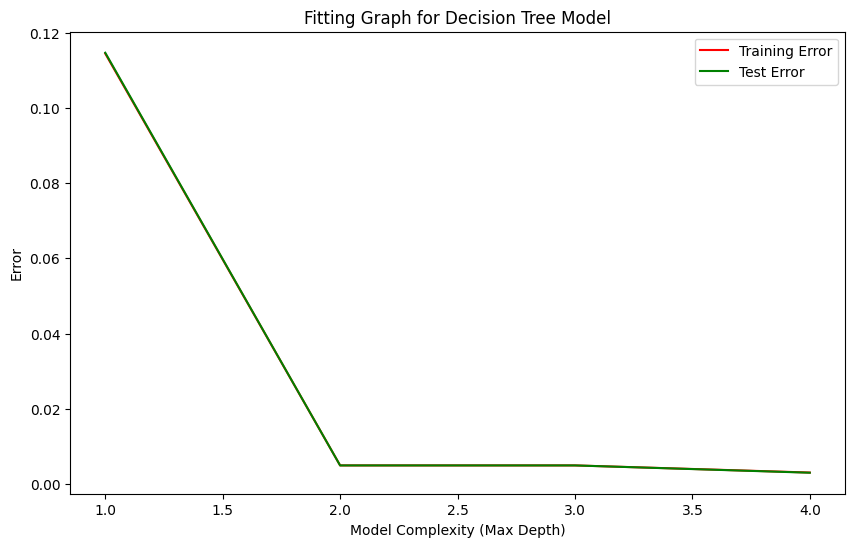

In [22]:
train_data = assembler.transform(hh_train)
test_data = assembler.transform(hh_test)

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt

# we can adjust the depth, but since it is a simple model we can start small first and adjust later
max_depths = range(1, 5)  

#create empty list of training and testing errors for plotting
train_errors = []
test_errors = []

# let us first define the Multiclass Classification Evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="OWNERSHP", predictionCol="prediction", metricName="accuracy")

for depth in max_depths:
    # creating the Decision Tree model for current depth
    dt_classifier = DecisionTreeClassifier(labelCol="OWNERSHP", featuresCol="features", maxDepth=depth)
    
    # fitting and training model
    model = dt_classifier.fit(train_data)
    
    # calculating training error for current depth
    train_predictions = model.transform(train_data)
    train_accuracy = evaluator.evaluate(train_predictions)
    train_error = 1 - train_accuracy
    train_errors.append(train_error)
    
    # calculating test error for current depth
    test_predictions = model.transform(test_data)
    test_accuracy = evaluator.evaluate(test_predictions)
    test_error = 1 - test_accuracy
    test_errors.append(test_error)

# Plot the training and test errors
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_errors, label='Training Error', color='red')
plt.plot(max_depths, test_errors, label='Test Error', color='green')
plt.xlabel('Model Complexity (Max Depth)')
plt.ylabel('Error')
plt.title('Fitting Graph for Decision Tree Model')
plt.legend()
plt.show()

The training error and test error seem to be very consistent. This could be because the model is very simple and converges quickly. We will look into this more as we take our next steps.

In [15]:
df_hh.show()

+----+------+------+-------------+-------+------+-------------+-----+--------+-------+------+---+----+--------+---------+-------+-------+--------+-------+--------+----------+-----+------------------+---------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|YEAR|SAMPLE|SERIAL|     CBSERIAL|   HHWT|HHTYPE|      CLUSTER|CPI99|STATEICP|MET2023|STRATA| GQ|FARM|OWNERSHP|OWNERSHPD|TAXINCL|INSINCL|FOODSTMP|CINETHH|VEHICLES|COUPLETYPE|NFAMS|          ARENTGRS|ACONDOFEE|         AMOBLHOME|         AHHINCOME|           AVALUEH|         ACOSTELEC|          ACOSTGAS|         ACOSTWATR|         ACOSTFUEL|
+----+------+------+-------------+-------+------+-------------+-----+--------+-------+------+---+----+--------+---------+-------+-------+--------+-------+--------+----------+-----+------------------+---------+------------------+------------------+------------------+------------------+------------------+----------

### New Model Predicting Ability to Own

### Without "AVALUEH"

In [16]:
new = df_hh.filter(df_hh.OWNERSHP != 0)
feature_columns = ["HHTYPE", "VEHICLES", "NFAMS", "AHHINCOME"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(new)
hh_norm_train, hh_norm_test = data.randomSplit(weights=[0.8,0.2], seed=200)

In [17]:
logistic_regression = LogisticRegression(featuresCol="features", labelCol="OWNERSHP")
model = logistic_regression.fit(hh_norm_train)

predictions = model.transform(hh_norm_test)

# AUC-ROC
##auc = evaluator.evaluate(predictions)

# Accuracy, Precision, and Recall
multi_evaluator = MulticlassClassificationEvaluator(labelCol="OWNERSHP", predictionCol="prediction")
accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})

#print(f"AUC-ROC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.7404
Precision: 0.7242
Recall: 0.7404


### With "AVALUEH"

In [18]:
new = df_hh.filter(df_hh.OWNERSHP != 0)
feature_columns = ["HHTYPE", "VEHICLES", "NFAMS", "AHHINCOME", "AVALUEH"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(new)
hh_norm_train, hh_norm_test = data.randomSplit(weights=[0.8,0.2], seed=200)

In [19]:
logistic_regression = LogisticRegression(featuresCol="features", labelCol="OWNERSHP")
model = logistic_regression.fit(hh_norm_train)

predictions = model.transform(hh_norm_test)

# AUC-ROC
##auc = evaluator.evaluate(predictions)

# Accuracy, Precision, and Recall
multi_evaluator = MulticlassClassificationEvaluator(labelCol="OWNERSHP", predictionCol="prediction")
accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})

#print(f"AUC-ROC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


Combined Dataset

In [16]:
# Check for null values in feature columns
from pyspark.sql.functions import col, isnan, when, count

feature_columns = ["AGE", "MARST", "RACE", "CITIZEN", "EDUC", "CLASSWKR", "AFTOTINC", "NFAMS", "FAMSIZE", "GQ", "STATEICP", "CBPERNUM", "YEAR", "HHTYPE"]

new.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in feature_columns]).show()

# Fill or drop null values if any
new = new.na.fill(0, subset=feature_columns)
# Alternatively, you can drop rows with null values in the feature columns
# new = new.na.drop(subset=feature_columns)


+---+-----+----+-------+----+--------+--------+-----+-------+---+-------+--------+--------+----+------+
|AGE|MARST|RACE|CITIZEN|EDUC|CLASSWKR|AFTOTINC|NFAMS|FAMSIZE| GQ|MET2023|STATEICP|CBPERNUM|YEAR|HHTYPE|
+---+-----+----+-------+----+--------+--------+-----+-------+---+-------+--------+--------+----+------+
|  0|    0|   0|      0|   0|       0|       0|    0|      0|  0|2500079|       0|       0|   0|     0|
+---+-----+----+-------+----+--------+--------+-----+-------+---+-------+--------+--------+----+------+



In [17]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# Assuming result_df is already loaded
new = result_df.filter(result_df.OWNERSHP != 0)

# Define the feature columns
feature_columns = ["AGE", "MARST", "RACE", "CITIZEN", "EDUC", "CLASSWKR", "AFTOTINC", "NFAMS", "FAMSIZE", "GQ", "STATEICP", "CBPERNUM", "YEAR", "HHTYPE"]

# Assemble feature columns into a feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="OWNERSHP", featuresCol="features")

# Create a pipeline
pipeline = Pipeline(stages=[assembler, dt])

# Train the model
model = pipeline.fit(new)

# Make predictions
predictions = model.transform(new)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="OWNERSHP", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

# Show predictions
predictions.select("OWNERSHP", "prediction", "probability").show()


Accuracy: 0.779417370411095


+--------+----------+--------------------+
|OWNERSHP|prediction|         probability|
+--------+----------+--------------------+
|       1|       1.0|[0.0,0.8896445375...|
|       1|       1.0|[0.0,0.8896445375...|
|       1|       1.0|[0.0,0.8896445375...|
|       1|       1.0|[0.0,0.6890199342...|
|       2|       1.0|[0.0,0.8896445375...|
|       2|       1.0|[0.0,0.8896445375...|
|       2|       1.0|[0.0,0.8896445375...|
|       2|       1.0|[0.0,0.8896445375...|
|       2|       1.0|[0.0,0.8049744562...|
|       1|       1.0|[0.0,0.6890199342...|
|       1|       1.0|[0.0,0.6890199342...|
|       1|       1.0|[0.0,0.6890199342...|
|       2|       2.0|[0.0,0.4690194629...|
|       2|       2.0|[0.0,0.4690194629...|
|       2|       1.0|[0.0,0.8896445375...|
|       2|       1.0|[0.0,0.8896445375...|
|       2|       1.0|[0.0,0.7439311910...|
|       2|       2.0|[0.0,0.4690194629...|
|       2|       1.0|[0.0,0.8896445375...|
|       2|       1.0|[0.0,0.6890199342...|
+--------+-

In [46]:
# Print the decision tree model
model = model.stages[-1]

# Mapping of features
feature_mapping = {
    0: "AGE",
    1: "MARST",
    2: "RACE",
    3: "CITIZEN",
    4: "EDUC",
    5: "CLASSWKR",
    6: "AFTOTINC",
    7: "NFAMS",
    8: "FAMSIZE",
    9: "GQ",
    10: "STATEICP",
    11: "CBPERNUM",
    12: "YEAR",
    13: "HHTYPE"
}
# Mapping of predicted class 
class_mapping = {
    0.0: "Na",
    1.0: "Own",
    2.0: "Rent"
}

# replace feature numbers and predicted class numbers with names and labels
def convert_tree_structure(tree_structure):
    lines = tree_structure.split("\n")
    converted_lines = []
    for line in lines:
        for feature_num, feature_name in feature_mapping.items():
            line = line.replace(f"feature {feature_num} ", f"{feature_name} ")
            line = line.replace(f"feature {feature_num}>", f"{feature_name}>")
            line = line.replace(f"feature {feature_num}<=", f"{feature_name}<=")
        for class_num, class_label in class_mapping.items():
            line = line.replace(f"Predict: {class_num}", f"Predict: {class_label}")
        converted_lines.append(line)
    return "\n".join(converted_lines)

tree_structure = model.toDebugString
converted_tree_structure = convert_tree_structure(tree_structure)
print(converted_tree_structure)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_eed58756ec55, depth=5, numNodes=29, numClasses=3, numFeatures=14
  If (AFTOTINC <= 37544.7)
   If (AGE <= 48.5)
    If (HHTYPE <= 2.5)
     If (CITIZEN <= 2.5)
      Predict: Own
     Else (CITIZEN > 2.5)
      Predict: Rent
    Else (HHTYPE > 2.5)
     Predict: Rent
   Else (AGE > 48.5)
    If (HHTYPE <= 1.5)
     Predict: Own
    Else (HHTYPE > 1.5)
     If (RACE <= 1.5)
      Predict: Own
     Else (RACE > 1.5)
      If (AFTOTINC <= 13960.74)
       Predict: Rent
      Else (AFTOTINC > 13960.74)
       Predict: Own
  Else (AFTOTINC > 37544.7)
   If (HHTYPE <= 1.5)
    If (CITIZEN <= 2.5)
     Predict: Own
    Else (CITIZEN > 2.5)
     If (AGE <= 42.5)
      If (AFTOTINC <= 80590.45999999999)
       Predict: Rent
      Else (AFTOTINC > 80590.45999999999)
       Predict: Own
     Else (AGE > 42.5)
      Predict: Own
   Else (HHTYPE > 1.5)
    If (AGE <= 45.5)
     If (HHTYPE <= 3.5)
      Predict: Own
     Else (HHTYPE > 3.5)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_eed58756ec55, depth=5, numNodes=29, numClasses=3, numFeatures=14
  If (feature 6 <= 37544.7)
   If (feature 0 <= 48.5)
    If (feature 13 <= 2.5)
     If (feature 3 <= 2.5)
      Predict: 1.0
     Else (feature 3 > 2.5)
      Predict: 2.0
    Else (feature 13 > 2.5)
     Predict: 2.0
   Else (feature 0 > 48.5)
    If (feature 13 <= 1.5)
     Predict: 1.0
    Else (feature 13 > 1.5)
     If (feature 2 <= 1.5)
      Predict: 1.0
     Else (feature 2 > 1.5)
      If (feature 6 <= 13960.74)
       Predict: 2.0
      Else (feature 6 > 13960.74)
       Predict: 1.0
  Else (feature 6 > 37544.7)
   If (feature 13 <= 1.5)
    If (feature 3 <= 2.5)
     Predict: 1.0
    Else (feature 3 > 2.5)
     If (feature 0 <= 42.5)
      If (feature 6 <= 80590.45999999999)
       Predict: 2.0
      Else (feature 6 > 80590.45999999999)
       Predict: 1.0
     Else (feature 0 > 42.5)
      Predict: 1.0
   Else (feature 13 > 1.5)
    If (feature 0 <=

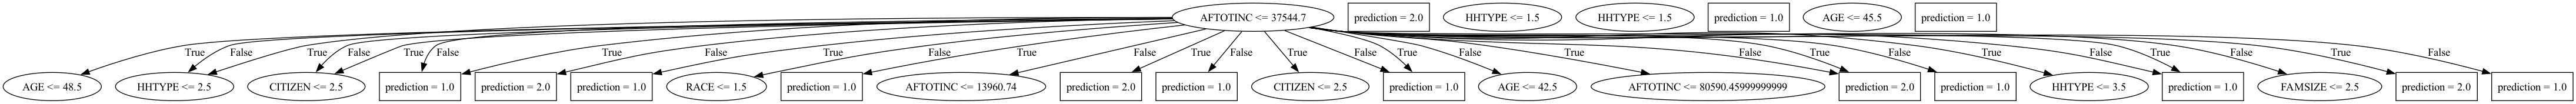

In [44]:
from graphviz import Source
import re

def parse_debug_string(debug_string):
    lines = debug_string.splitlines()
    nodes = {}
    edges = []
    node_id = 0

    def parse_node(line, indent_level):
        nonlocal node_id
        split_pattern = re.compile(r"If \(feature (\d+) <= ([\d\.]+)\)")
        predict_pattern = re.compile(r"Predict: ([\d\.]+)")

        split_match = split_pattern.search(line)
        predict_match = predict_pattern.search(line)

        if split_match:
            feature_index = int(split_match.group(1))
            threshold = float(split_match.group(2))
            nodes[node_id] = {"split": (feature_index, threshold), "indent": indent_level}
            left_child_id = node_id + 1
            right_child_id = node_id + 2
            node_id += 1
            return left_child_id, right_child_id
        elif predict_match:
            prediction = float(predict_match.group(1))
            nodes[node_id] = {"prediction": prediction, "indent": indent_level}
            node_id += 1
            return None, None
        else:
            return None, None  # Return None if neither split nor prediction is found


    stack = [(0, 0)]  # (node_id, indent_level)

    for line in lines[1:]:
        if line.strip():
            indent_level = len(line) - len(line.lstrip())
            while stack and stack[-1][1] >= indent_level:
                stack.pop()
            current_node_id, _ = stack[-1]
            left_child_id, right_child_id = parse_node(line.strip(), indent_level)
            if left_child_id is not None and right_child_id is not None:
                edges.append((current_node_id, left_child_id, True))
                edges.append((current_node_id, right_child_id, False))
                stack.append((left_child_id, indent_level + 1))
                stack.append((right_child_id, indent_level + 1))

    return nodes, edges

def decision_tree_to_dot(nodes, edges, feature_names):
    dot = ["digraph DecisionTree {"]

    for node_id, node_info in nodes.items():
        if "split" in node_info:
            feature_index, threshold = node_info["split"]
            feature_name = feature_names[feature_index]
            label = f"{feature_name} <= {threshold}"
            dot.append(f'  node{node_id} [label="{label}", shape=ellipse];')
        else:
            label = f"prediction = {node_info['prediction']}"
            dot.append(f'  node{node_id} [label="{label}", shape=box];')

    for parent, child, is_left in edges:
        label = "True" if is_left else "False"
        dot.append(f'  node{parent} -> node{child} [label="{label}"];')

    dot.append("}")
    return "\n".join(dot)

# Parse the debug string
debug_string = dt_model.toDebugString
#print(debug_string)  # Inspect the debug string output

nodes, edges = parse_debug_string(debug_string)

# Generate the DOT format string
dot_data = decision_tree_to_dot(nodes, edges, feature_columns)

# Print the DOT data for debugging
print("DOT data:")
print(dot_data)

# Use graphviz to render the DOT string into an image
graph = Source(dot_data)
graph.render("decision_tree", format="png", cleanup=True)

# Display the image (optional, depends on the environment)
from IPython.display import Image
display(Image(filename="decision_tree.png"))


In [47]:
# Assuming result_df is already loaded
new = result_df.filter(result_df.OWNERSHP != 0)

# Define the feature columns
feature_columns = ["AGE", "MARST", "RACE", "CITIZEN", "EDUC", "CLASSWKR", "NFAMS", "FAMSIZE", "GQ", "STATEICP", "CBPERNUM", "YEAR", "HHTYPE"]

# Assemble feature columns into a feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="OWNERSHP", featuresCol="features")

# Create a pipeline
pipeline = Pipeline(stages=[assembler, dt])

# Train the model
model = pipeline.fit(new)

# Make predictions
predictions = model.transform(new)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="OWNERSHP", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.768293321931027


In [48]:
# Print the decision tree model
model = model.stages[-1]

# Mapping of features
feature_mapping = {
    0: "AGE",
    1: "MARST",
    2: "RACE",
    3: "CITIZEN",
    4: "EDUC",
    5: "CLASSWKR",
    6: "NFAMS",
    7: "FAMSIZE",
    8: "GQ",
    9: "STATEICP",
    10: "CBPERNUM",
    11: "YEAR",
    12: "HHTYPE"
}
# Mapping of predicted class 
class_mapping = {
    0.0: "Na",
    1.0: "Own",
    2.0: "Rent"
}

# replace feature numbers and predicted class numbers with names and labels
def convert_tree_structure(tree_structure):
    lines = tree_structure.split("\n")
    converted_lines = []
    for line in lines:
        for feature_num, feature_name in feature_mapping.items():
            line = line.replace(f"feature {feature_num} ", f"{feature_name} ")
            line = line.replace(f"feature {feature_num}>", f"{feature_name}>")
            line = line.replace(f"feature {feature_num}<=", f"{feature_name}<=")
        for class_num, class_label in class_mapping.items():
            line = line.replace(f"Predict: {class_num}", f"Predict: {class_label}")
        converted_lines.append(line)
    return "\n".join(converted_lines)

tree_structure = model.toDebugString
converted_tree_structure = convert_tree_structure(tree_structure)
print(converted_tree_structure)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_02b3d36ecdd9, depth=5, numNodes=35, numClasses=3, numFeatures=13
  If (HHTYPE <= 1.5)
   If (CITIZEN <= 2.5)
    Predict: Own
   Else (CITIZEN > 2.5)
    If (AGE <= 42.5)
     If (AGE <= 34.5)
      If (CBPERNUM <= 4.5)
       Predict: Rent
      Else (CBPERNUM > 4.5)
       Predict: Own
     Else (AGE > 34.5)
      If (CBPERNUM <= 1.5)
       Predict: Rent
      Else (CBPERNUM > 1.5)
       Predict: Own
    Else (AGE > 42.5)
     Predict: Own
  Else (HHTYPE > 1.5)
   If (AGE <= 45.5)
    If (FAMSIZE <= 1.5)
     If (AGE <= 29.5)
      If (HHTYPE <= 3.5)
       Predict: Own
      Else (HHTYPE > 3.5)
       Predict: Rent
     Else (AGE > 29.5)
      Predict: Rent
    Else (FAMSIZE > 1.5)
     If (RACE <= 1.5)
      If (CBPERNUM <= 1.5)
       Predict: Rent
      Else (CBPERNUM > 1.5)
       Predict: Own
     Else (RACE > 1.5)
      If (EDUC <= 7.5)
       Predict: Rent
      Else (EDUC > 7.5)
       Predict: Own
   Else (AGE > 

In [12]:
new = result_df.filter(result_df.OWNERSHP != 0)
feature_columns = ["AGE", "MARST", "RACE", "CITIZEN", "EDUC", "CLASSWKR", "AFTOTINC", "NFAMS", "FAMSIZE", "GQ", "MET2023", "STATEICP", "CBPERNUM", "YEAR", "HHTYPE"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(new)
norm_train, norm_test = data.randomSplit(weights=[0.8,0.2], seed=200)

In [14]:
logistic_regression = LogisticRegression(featuresCol="features", labelCol="OWNERSHP")
model = logistic_regression.fit(norm_train)

predictions = model.transform(norm_test)

# AUC-ROC
##auc = evaluator.evaluate(predictions)

# Accuracy, Precision, and Recall
multi_evaluator = MulticlassClassificationEvaluator(labelCol="OWNERSHP", predictionCol="prediction")
accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})

#print(f"AUC-ROC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

24/06/08 09:37:11 ERROR Executor: Exception in task 1.0 in stage 68.0 (TID 359)]
org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$4356/949631386`: (struct<AGE_double_VectorAssembler_8449788eef09:double,MARST_double_VectorAssembler_8449788eef09:double,RACE_double_VectorAssembler_8449788eef09:double,CITIZEN_double_VectorAssembler_8449788eef09:double,EDUC_double_VectorAssembler_8449788eef09:double,CLASSWKR_double_VectorAssembler_8449788eef09:double,AFTOTINC:double,NFAMS_double_VectorAssembler_8449788eef09:double,FAMSIZE_double_VectorAssembler_8449788eef09:double,GQ_double_VectorAssembler_8449788eef09:double,MET2023_double_VectorAssembler_8449788eef09:double,STATEICP_double_VectorAssembler_8449788eef09:double,CBPERNUM_double_VectorAssembler_8449788eef09:double,YEAR_double_VectorAssembler_8449788eef09:double,HHTYPE_double_VectorAssembler_8449788eef09:double>) => struct<type:tinyint,size:int,indices:array<int>,values:arra

Py4JJavaError: An error occurred while calling o332.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 68.0 failed 1 times, most recent failure: Lost task 1.0 in stage 68.0 (TID 359) (192.168.4.60 executor driver): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$4356/949631386`: (struct<AGE_double_VectorAssembler_8449788eef09:double,MARST_double_VectorAssembler_8449788eef09:double,RACE_double_VectorAssembler_8449788eef09:double,CITIZEN_double_VectorAssembler_8449788eef09:double,EDUC_double_VectorAssembler_8449788eef09:double,CLASSWKR_double_VectorAssembler_8449788eef09:double,AFTOTINC:double,NFAMS_double_VectorAssembler_8449788eef09:double,FAMSIZE_double_VectorAssembler_8449788eef09:double,GQ_double_VectorAssembler_8449788eef09:double,MET2023_double_VectorAssembler_8449788eef09:double,STATEICP_double_VectorAssembler_8449788eef09:double,CBPERNUM_double_VectorAssembler_8449788eef09:double,YEAR_double_VectorAssembler_8449788eef09:double,HHTYPE_double_VectorAssembler_8449788eef09:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage6.hashAgg_ScalaUDF_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage6.hashAgg_doAggregateWithKeysOutput_1$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage6.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage6.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1264)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1265)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 41 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2493)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1202)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1196)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$2(RDD.scala:1289)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1256)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1242)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1242)
	at org.apache.spark.ml.stat.Summarizer$.getClassificationSummarizers(Summarizer.scala:233)
	at org.apache.spark.ml.classification.LogisticRegression.$anonfun$train$1(LogisticRegression.scala:517)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:497)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:287)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$4356/949631386`: (struct<AGE_double_VectorAssembler_8449788eef09:double,MARST_double_VectorAssembler_8449788eef09:double,RACE_double_VectorAssembler_8449788eef09:double,CITIZEN_double_VectorAssembler_8449788eef09:double,EDUC_double_VectorAssembler_8449788eef09:double,CLASSWKR_double_VectorAssembler_8449788eef09:double,AFTOTINC:double,NFAMS_double_VectorAssembler_8449788eef09:double,FAMSIZE_double_VectorAssembler_8449788eef09:double,GQ_double_VectorAssembler_8449788eef09:double,MET2023_double_VectorAssembler_8449788eef09:double,STATEICP_double_VectorAssembler_8449788eef09:double,CBPERNUM_double_VectorAssembler_8449788eef09:double,YEAR_double_VectorAssembler_8449788eef09:double,HHTYPE_double_VectorAssembler_8449788eef09:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage6.hashAgg_ScalaUDF_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage6.hashAgg_doAggregateWithKeysOutput_1$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage6.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage6.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1264)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1265)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 41 more
